In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics as metrics

In [3]:
folder = "/home/user/Documents/St.Olaf/Csci379/karase1/project_02/python_data_objects/"
from joblib import load
# train_images = load(folder+'train_images.joblib')
# train_labels = load(folder+'train_labels.joblib')
# valid_images = load(folder+'valid_images.joblib')
# valid_labels = load(folder+'valid_labels.joblib')
# test_images = load(folder+'test_images.joblib')
# test_labels = load(folder+'test_labels.joblib')
train_images = load(folder+'train_images_not_standardized.joblib')
train_labels = load(folder+'train_labels_not_standardized.joblib')
valid_images = load(folder+'valid_images_not_standardized.joblib')
valid_labels = load(folder+'valid_labels_not_standardized.joblib')
test_images = load(folder+'test_images_not_standardized.joblib')
test_labels = load(folder+'test_labels_not_standardized.joblib')

In [4]:
model1 = Sequential([
  layers.Rescaling(1./255, input_shape=(180, 180, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(200, activation='softmax')
])

In [5]:
batch_size = 32

model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [6]:
#we get the best 
history1 = model1.fit(train_images, train_labels, batch_size=batch_size,
                            epochs=4, validation_data=(valid_images, valid_labels))
#after the 4th epoch, the validation data accuracy starts dropping while training accuracy keeps growing - overfitting

Epoch 1/4
1186/1186 [==============================] - 128s 107ms/step - loss: 4.6464 - accuracy: 0.0399 - val_loss: 4.1581 - val_accuracy: 0.0874
Epoch 2/4
1186/1186 [==============================] - 125s 105ms/step - loss: 3.6223 - accuracy: 0.1585 - val_loss: 3.7112 - val_accuracy: 0.1530
Epoch 3/4
1186/1186 [==============================] - 126s 106ms/step - loss: 2.7775 - accuracy: 0.3177 - val_loss: 3.7346 - val_accuracy: 0.1664
Epoch 4/4
1186/1186 [==============================] - 126s 107ms/step - loss: 1.9321 - accuracy: 0.5051 - val_loss: 4.2889 - val_accuracy: 0.1723


In [7]:
test_loss1, test_accuracy1 = model1.evaluate(test_images, test_labels, verbose=2)

print(f'CNN Test Accuracy: {test_accuracy1 * 100:.2f}%')
print(f'CNN Test Loss: {test_loss1:.4f}')

141/141 - 6s - loss: 4.5013 - accuracy: 0.1386 - 6s/epoch - 45ms/step
CNN Test Accuracy: 13.86%
CNN Test Loss: 4.5013


In [15]:
#add batch normalization layers
#experiment with kernel sizes

batch_size = 32
model2 = Sequential([
  layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    
  layers.Conv2D(16, (2,2), padding='valid', activation='relu',input_shape=(180, 180, 3)),
  #layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.1),
    
  layers.Conv2D(32, (3,3), padding='valid', activation='relu'),
  #layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(4, 4)),
  layers.Dropout(0.1),
    
  layers.Conv2D(64, (5,5), padding='valid', activation='relu'),
  #layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(6, 6)),
  layers.Dropout(0.1),
    
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(200, activation='softmax')
])

#SUMMARIZE THE FOLLOWING INTO THE PAPER
#added a dropout layer (0.1) after each pooling layer, the best validation set performance 7th epoch, 17.02%,test performance 15.68%
#dropout rate 0.1 seems to work better that 0.2. 0.6 was brutal
#removing all except the second to last dropout layer - best val_acc 15.11%, test data accuracy 13.02%
#returned back the dropout layers, added the input shape parameter, changed padding to "valid", best of 16.57% on valid
#changed kernel sizes to (2,2), (3,3), (5,5) - improvement - val_acc 19.12% 4th epoch, test_acc 16.1% (after all epochs - started getting worse after 5)- explore more
#added batch normalization layers - the model went to shit here- not getting better than 0.5% - got something wrong that is for sure
#removed the batch normalization layers and changed dropout rates to 0.2 again - similar to model with 0.1 rate
#removed all dropouts - got worse - valid 17.13%, test 16.10%
    #the dropout layers could worsen the performance because all non-zero data is the bird itself which matters
#try dropouts only in later layers where essentially all other 0s from the background are gone?
#changed pool sizes: (2,2), (3,3), (4,4) -> big improvements - 7th epoch 27.57% valid, 26.71% test, 8th v28.16% t26.33%  
#changed pool sizes: (2,2), (4,4), (6,6) -> after 13 or 14 epochs v30.45%- run again when time just to get the correct data for paper


#Add dense layers in between!!


#add sets of layers once I figure out which work generally the best

In [16]:
#add scheduler to adam
from keras.optimizers import Adam
model2.compile(optimizer = Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [17]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 179, 179, 16)      208       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 16)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 89, 89, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 21, 21, 32)        0         
 g2D)                                                 

In [20]:
history2 = model2.fit(train_images, train_labels, batch_size=batch_size,
                            epochs=10, validation_data=(valid_images, valid_labels))

Epoch 1/10
1186/1186 [==============================] - 115s 97ms/step - loss: 2.8082 - accuracy: 0.2838 - val_loss: 3.0975 - val_accuracy: 0.2504
Epoch 2/10
1186/1186 [==============================] - 118s 99ms/step - loss: 2.7037 - accuracy: 0.3074 - val_loss: 3.0192 - val_accuracy: 0.2746
Epoch 3/10
1186/1186 [==============================] - 115s 97ms/step - loss: 2.6158 - accuracy: 0.3230 - val_loss: 3.0470 - val_accuracy: 0.2670
Epoch 4/10
1186/1186 [==============================] - 119s 101ms/step - loss: 2.5408 - accuracy: 0.3374 - val_loss: 2.9878 - val_accuracy: 0.2778
Epoch 5/10
1186/1186 [==============================] - 116s 98ms/step - loss: 2.4670 - accuracy: 0.3530 - val_loss: 2.9866 - val_accuracy: 0.2844
Epoch 6/10
1186/1186 [==============================] - 116s 98ms/step - loss: 2.4088 - accuracy: 0.3664 - val_loss: 2.9509 - val_accuracy: 0.3045
Epoch 7/10
1186/1186 [==============================] - 118s 99ms/step - loss: 2.3634 - accuracy: 0.3726 - val_loss: 

In [21]:
test_loss2, test_accuracy2 = model2.evaluate(test_images, test_labels, verbose=2)

print(f'CNN Test Accuracy: {test_accuracy2 * 100:.2f}%')
print(f'CNN Test Loss: {test_loss2:.4f}')

141/141 - 5s - loss: 3.1321 - accuracy: 0.2855 - 5s/epoch - 35ms/step
CNN Test Accuracy: 28.55%
CNN Test Loss: 3.1321


In [4]:
batch_size = 32
model3 = Sequential([
  layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    
  layers.Conv2D(32, (2,2), padding='valid', activation='relu',input_shape=(180, 180, 3)),
  #layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
  #layers.Dropout(0.1),
    
  layers.Conv2D(32, (2,2), padding='valid', activation='relu'),
  #layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.1),

  layers.Conv2D(64, (3,3), padding='valid', activation='relu'),
  #layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(3, 3)),
  layers.Dropout(0.1),

  layers.Conv2D(128, (5,5), padding='valid', activation='relu'),
  #layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(5, 5)),
  layers.Dropout(0.1),
    
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(200, activation='softmax')
])

#11th epoch v33.83%, t34.83%
#doubled each number of factors - essentially no improvement
#decreased pool sizes but increased number of layer sets - worsened the model
#added 0.1 dropout layer after the first set - not much difference v35.21%, t32.28%, 
#changed 2nd conv to from (2,2) to (3,3), 3rd from (3,3) to (4,4), and 4th to (6,6) - worse results 
#add more dense layers at the end?

In [5]:
from keras.optimizers import Adam
#add the scheduler (to the simple model first to see if it makes a difference)
model3.compile(optimizer = Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 179, 179, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 88, 88, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 44, 44, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 44, 44, 32)        0

In [6]:
history3 = model3.fit(train_images, train_labels, batch_size=batch_size,
                            epochs=15, validation_data=(valid_images, valid_labels))
#started with 15

Epoch 1/15
1186/1186 [==============================] - 177s 148ms/step - loss: 4.6630 - accuracy: 0.0364 - val_loss: 4.0272 - val_accuracy: 0.0925
Epoch 2/15
1186/1186 [==============================] - 176s 149ms/step - loss: 3.7188 - accuracy: 0.1180 - val_loss: 3.4277 - val_accuracy: 0.1812
Epoch 3/15
1186/1186 [==============================] - 174s 147ms/step - loss: 3.2520 - accuracy: 0.1969 - val_loss: 3.1637 - val_accuracy: 0.2201
Epoch 4/15
1186/1186 [==============================] - 179s 151ms/step - loss: 2.9492 - accuracy: 0.2529 - val_loss: 3.0002 - val_accuracy: 0.2581
Epoch 5/15
1186/1186 [==============================] - 177s 149ms/step - loss: 2.7194 - accuracy: 0.3005 - val_loss: 2.8842 - val_accuracy: 0.2927
Epoch 6/15
1186/1186 [==============================] - 177s 149ms/step - loss: 2.5295 - accuracy: 0.3407 - val_loss: 2.8627 - val_accuracy: 0.2927
Epoch 7/15
1186/1186 [==============================] - 176s 149ms/step - loss: 2.3700 - accuracy: 0.3709 - val_

In [9]:
test_loss3, test_accuracy3 = model3.evaluate(test_images, test_labels, verbose=2)

print(f'CNN Test Accuracy: {test_accuracy3 * 100:.2f}%')
print(f'CNN Test Loss: {test_loss3:.4f}')

141/141 - 8s - loss: 2.8482 - accuracy: 0.3429 - 8s/epoch - 57ms/step
CNN Test Accuracy: 34.29%
CNN Test Loss: 2.8482


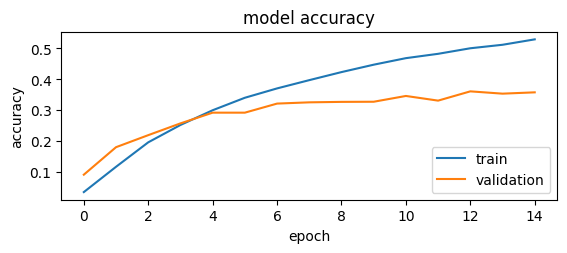

In [10]:
plt.subplot(2,1,1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')

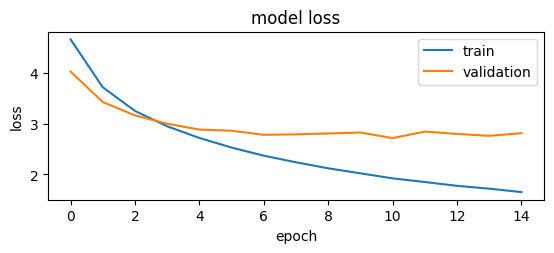

In [11]:
plt.subplot(2,1,2)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')